## BERT fine tunning
*Based on [BERT Fine-Tuning Sentence Classification notebook on Colab](https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=6J-FYdx6nFE_)

We will use BERT implementation from `pytorch-transformers` library, which contains almost all recent architectures.

In [1]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 8.7MB/s 
     |████████████████████████████████| 890kB 15.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=3cef633b1c8fbed533f43c1a9c97755c956d3b16a345d62d87262ca6159aec2f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


Если у вас есть GPU, будем использовать ее для обучения. Тем не менее, этот ноутбук можно выполнить и с помощью только CPU. Правда, это будет значительно дольше.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla P100-PCIE-16GB GPUs


## Загрузка данных


Мы выбрали не очень известный, необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

Но и wget сойдет, сайт без аутентификации и потому скать просто.

In [4]:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0

--2020-07-15 10:26:03--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2020-07-15 10:26:03--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1050ef87a445a8574fcc7de9a0.dl.dropboxusercontent.com/cd/0/inline/A7mU6RHhbQ_--fCuUIwZSqeOKNUCMk1rvwqCshaZwEfMb_6dGsq-CkTjb5sOxL5Ii1yInCj1VEarikgaC6vntTxtKNroN2fSvPNxpHtogFnL_g/file# [following]
--2020-07-15 10:26:03--  https://uc1050ef87a445a8574fcc7de9a0.dl.dropboxusercontent.com/cd/0/inline/A7mU6RHhbQ_--fCuUIwZSqeOKNUCMk1rvwqCshaZwEfMb_6dGsq-CkTjb5sOxL5Ii1yInCj1VEarikgaC6vntTxtKNroN2fSvPNxpHtogFnL_g/file
Resolving u

In [5]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0

--2020-07-15 10:26:08--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2020-07-15 10:26:09--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc36031389b61b3493f3f9bc803d.dl.dropboxusercontent.com/cd/0/inline/A7lJpPqc811NfH-q40zkD1CQ9uk6fKWLqesO-UHyd-zDzXzCA8RWBMR9okgc2BvcyXi-JUOggrm7kWvPCTXmQF6m3tyzNP8lQAaeMDMUKW0riQ/file# [following]
--2020-07-15 10:26:09--  https://uc36031389b61b3493f3f9bc803d.dl.dropboxusercontent.com/cd/0/inline/A7lJpPqc811NfH-q40zkD1CQ9uk6fKWLqesO-UHyd-zDzXzCA8RWBMR9okgc2BvcyXi-JUOggrm7kWvPCTXmQF6m3tyzNP8lQAaeMDMUKW0riQ/file
Resolving u

In [6]:
!ls

'negative.csv?dl=0'  'positive.csv?dl=0'   sample_data


In [7]:
import pandas as pd


pos_texts = pd.read_csv('positive.csv?dl=0', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('negative.csv?dl=0', encoding='utf8', sep=';', header=None)

In [8]:
pos_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
8649,409111705256726528,1386374806,vemuvirycogyre,Офигенный день!\nдень позитива)\nбегал как иди...,1,0,0,0,308,254,251,0
21776,409427698600411137,1386450144,yaroslavkacenko,"Час ночи. Лег раньше:-) А завтра пердячить, оо...",1,0,0,0,670,10,38,0
86921,410809322554535936,1386779549,saida_kzn,@cheerful_rabbit нормааально:з из Казани :с\nЧ...,1,0,0,0,3827,104,118,0
36321,409829051822768128,1386545834,vitaliykylik,Ахахахахахахахах)) вот это называется 4 час но...,1,0,0,0,5165,273,182,1
22807,409484956420018176,1386463796,jilexowixag,не скрыть его приподнятого настроения! :DD htt...,1,0,0,0,414,167,183,0


Обратите внимание на специальные токены [CLS] и [SEP], которые мы добавляем в начало и конец предложения.

In [14]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]


In [15]:
assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]

In [16]:
print(sentences[1000])

[CLS] Дим, ты помогаешь мне, я тебе, все взаимно, все правильно) [SEP]


In [17]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [18]:
print(len(train_gt), len(test_gt))

158783 68051


## Inputs

Теперь импортируем токенизатор для BERT'а, который превратит наши тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [19]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 313598.85B/s]


['[CLS]', 'в', '##ы', '##д', '##а', '##л', '##и', '50', 'а', '##н', '##к', '##е', '##т', 'д', '##л', '##я', 'о', '##п', '##р', '##о', '##с', '##а', 'н', '##а', '##с', '##е', '##л', '##е', '##н', '##ия', '!', ')', ')', 'з', '##а', '##ч', '##е', '##т', 'п', '##о', 'с', '##о', '##ц', '##и', '##о', '##л', '##о', '##г', '##ии', 'и', 'н', '##е', '##м', '##н', '##о', '##г', '##о', 'д', '##е', '##н', '##е', '##г', 'п', '##е', '##р', '##е', '##д', 'н', '##ов', '##ы', '##м', 'г', '##о', '##д', '##о', '##м', 'н', '##е', 'п', '##о', '##м', '##е', '##ш', '##а', '##ю', '##т', '!', '!', ')', ')', '[SEP]']


BERT'у нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Выбираем максимально возможную длину предложения (в нашем случае пусть это будет 100). 

Теперь более длинные предложения будем обрезать до 100 токенов, а для более коротких использовать паддинг. Возьмем готовую функцию `pad_sequences` из библиотеки `keras`.



In [20]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Делим данные на `train` и `val`:

In [21]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

Преобразуем данные в `pytorch` тензоры:

In [22]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [23]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [24]:
train_labels

tensor([[0],
        [1],
        [0],
        ...,
        [1],
        [1],
        [0]])

Воспользуемся классом `DataLoader`. Это поможет нам использовать эффективнее память во время тренировки модели, так как нам не нужно будет загружать в память весь датасет. Данные по батчам будем разбивать произвольно с помощью RandomSampler. Также обратите внимание на размер батча: если во время тренировки возникнет `Memory Error`, размер батча необходимо уменьшить.

In [25]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [26]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Теперь когда данные подготовлены, надо написать пайплайн обучения модели.

Для начала мы хотим изменить предобученный BERT так, чтобы он выдавал метки для классификации текстов, а затем файнтюнить его на наших данных. Мы возьмем готовую модификацию BERTа для классификации из pytorch-transformers. Она интуитивно понятно называется `BertForSequenceClassification`. Это обычный BERT с добавленным линейным слоем для классификации.

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [27]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач. Все они построены на основе одной и той же архитектуры и различаются только верхними слоями.

In [28]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

Теперь подробнее рассмотрим процесс файн-тюнинга. Как мы помним, первый токен в каждом предложении - это `[CLS]`. В отличие от скрытого состояния, относящего к обычному слову (не метке `[CLS]`), скрытое состояние относящееся к этой метке должно содержать в себе аггрегированное представление всего предложения, которое дальше будет использоваться для классификации. Таким образом, когда мы скормили предложение в процессе обучения сети, выходом будет вектор со скрытым состоянием, относящийся к метке `[CLS]`. Дополнительный полносвязный слой, который мы добавили, имеет размер `[hidden_state, количество_классов]`, в нашем случае количество классов равно двум. То есть нав выходе мы получим два числа, представляющих классы "положительная эмоциональная окраска" и "отрицательная эмоциональная окраска".

Процесс дообучения достаточно дешев. По факту мы тренируем наш верхний слой и немного меняем веса во всех остальных слоях в процессе, чтобы подстроиться под нашу задачу.

Иногда некоторые слои специально "замораживают" или применяют разные стратегии работы с learning rate, в общем, делают все, чтобы сохранить "хорошие" веса в нижних слоях и ускорить дообучение. В целом, замораживание слоев BERTа обычно не сильно сказывается на итоговом качестве, однако надо помнить о тех случаях, когда данные, использованные для предобучения и дообучения очень разные (разные домены или стиль: академическая и разговорная лексика). В таких случаях лучше тренировать все слои сети, не замораживая ничего.

Загружаем BERT. `bert-base-uncased` - это версия "base" (в оригинальной статье рассказывается про две модели: "base" vs "large"), где есть только буквы в нижнем регистре ("uncased").

In [29]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

100%|██████████| 440473133/440473133 [00:35<00:00, 12300516.96B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Теперь обсудим гиперпараметры для обучения нашей модели. Авторы статьи советуют выбирать `learning rate` `5e-5`, `3e-5`, `2e-5`, а количество эпох не делать слишком большим, 2-4 вполне достаточно. Мы пойдем еще дальше и попробуем дообучить нашу модель всего за одну эпоху.

In [30]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



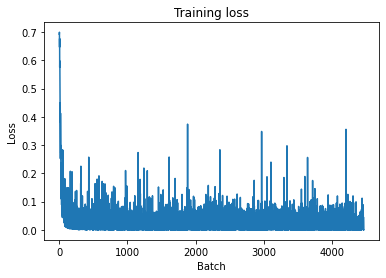

Loss на обучающей выборке: 0.03658
Процент правильных предсказаний на валидационной выборке: 97.86%


In [31]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [32]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 97.86%


# Оценка качества на отложенной выборке

Качество на валидационной выборке оказалось очень хорошим. Не переобучилась ли наша модель?

Делаем точно такую же предобработку для тестовых данных, как и в начале ноутбука делали для обучающих данных:

In [33]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

Создаем attention маски и приводим данные в необходимый формат:

In [34]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [35]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [38]:
acc_score

0.9790304330575598

In [39]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score * 100
))

Процент правильных предсказаний на отложенной выборке составил: 97.90%


In [ ]:
test_labels

In [42]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(np.array(test_labels) != np.array(test_preds)),
    len(test_labels)
))

Неправильных предсказаний: 1427/68051


### Оценка качества работы без fine-tuning

In [ ]:
model_wo_finetuning = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_wo_finetuning.cuda()

In [44]:
model_wo_finetuning.eval()
preds_wo_finetuning, labels_wo_finetuning = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model_wo_finetuning(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    preds_wo_finetuning.extend(batch_preds)
    labels_wo_finetuning.extend(batch_labels)

In [45]:
acc_score_wo_finetuning = accuracy_score(labels_wo_finetuning, preds_wo_finetuning)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score_wo_finetuning*100
))

Процент правильных предсказаний на отложенной выборке составил: 57.10%


Сравним точность и полноту предсказаний:

In [46]:
from sklearn.metrics import recall_score, precision_score

print('1 эпоха: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(test_labels, test_preds) * 100,
    recall_score(test_labels, test_preds) * 100
))
 
print('Без дообучения: точность (precision) {0:.2f}%, полнота (recall) {1:.2f}%'.format(
    precision_score(labels_wo_finetuning, preds_wo_finetuning) * 100,
    recall_score(labels_wo_finetuning, preds_wo_finetuning) * 100,
))

1 эпоха: точность (precision) 96.74%, полнота (recall) 99.19%
Без дообучения: точность (precision) 59.86%, полнота (recall) 45.78%


Итак, мы показали, что предобученный BERT может быстро (всего за одну эпоху) давать хорошее качество при решении задачи анализа эмоциональной окраски текстов. Обратите внимание, что мы не тюнили параметры и использовали сравнительно небольшой размеченный корпус, чтобы получить accuracy больше 98\%. Тем не менее, если не делать дообучения под конкретную задачу вовсе, получить хорошее качество не удается.

Кроме того, мы познакомились с библиотекой `pytorch-transformers`, которая позволяет использовать готовые обертки над моделями, специально созданными для решения той или иной задачи. Использовать BERT при решении повседневных NLP задач совсем нетрудно: не нужно даже вручную скачивать веса модели, библиотека все сделает за вас. Отбросив необходимость чуть-чуть предобработать тексты, сложность применения предобученного BERT'а оказывается не сильно больше, чем импортировать и применить лог.регрессию из `sklearn`.